In [59]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import seaborn as sns
from wordcloud import wordcloud
from tensorflow.keras import layers,models,losses, Sequential, optimizers, metrics

In [60]:
import tensorflow

print(tensorflow.__version__)

2.17.1


In [61]:
import keras
print(keras.__version__)

3.5.0


# Import data

In [62]:
twt_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sent Analysis/Tweets.csv')
twt_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [63]:
twt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [64]:
twt_df = twt_df.dropna()

In [65]:
# Check for null values in each column
twt_df.isnull().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0


In [66]:
twt_df.duplicated().sum()

0

In [67]:

# Drop selected text and textid
twt_df = twt_df.drop(columns = ["selected_text", "textID"])

In [68]:
twt_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [69]:
twt_df["sentiment"].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [70]:
import plotly.express as px

# Calculate value counts and reset index for Plotly Express
sentiment_counts = twt_df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']  # Rename columns

# Create the bar chart
fig = px.bar(
    sentiment_counts,
    x='sentiment',
    y='count',
    title='Distribution of Sentiments',
    labels={'sentiment': 'Sentiment', 'count': 'Number of Tweets'}
)
fig.show()

In [71]:
# obtain word count feature
twt_df["word_count"] = twt_df["text"].apply(lambda x: len(x.split(" ")))

In [72]:
twt_df.head()

,text,sentiment,word_count
0,"I`d have responded, if I were going",neutral,8
1,Sooo SAD I will miss you here in San Diego!!!,negative,11
2,my boss is bullying me...,negative,5
3,what interview! leave me alone,negative,6
4,"Sons of ****, why couldn`t they put them on t...",negative,15


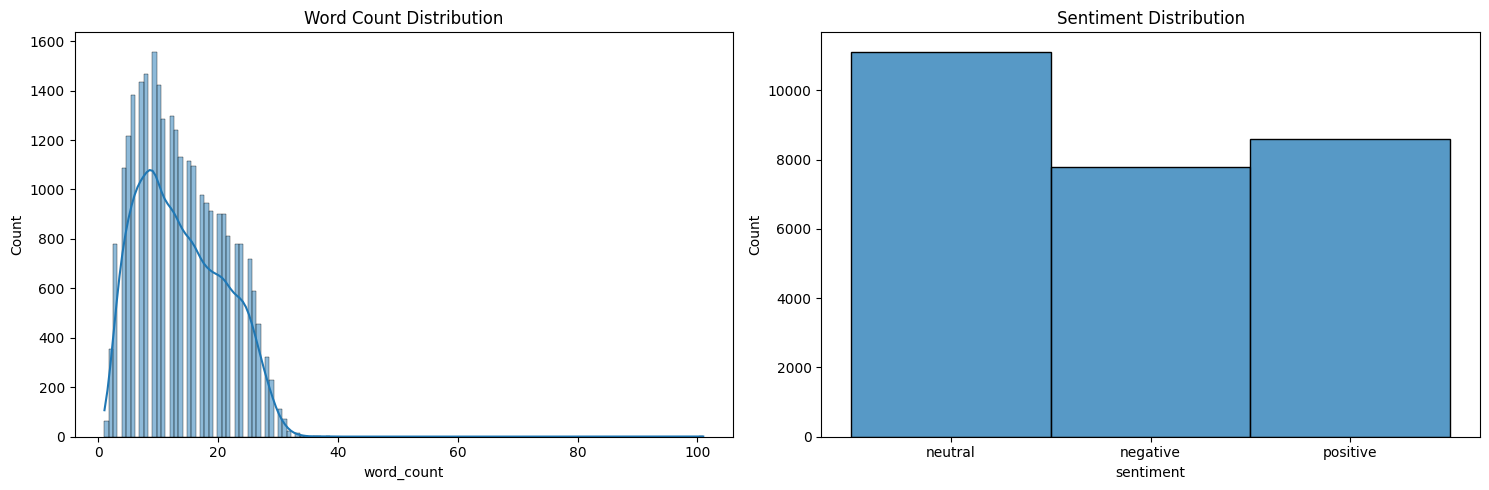

In [73]:
# prompt: create historgram plot of word_count and sentiment

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot word_count histogram
sns.histplot(twt_df['word_count'], ax=axes[0], kde=True)
axes[0].set_title('Word Count Distribution')

# Plot sentiment histogram
sns.histplot(twt_df['sentiment'], ax=axes[1])
axes[1].set_title('Sentiment Distribution')

plt.tight_layout()
plt.show()

<Axes: ylabel='word_count'>

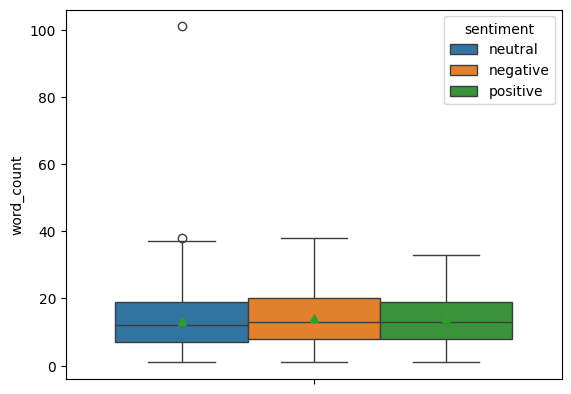

In [74]:
sns.boxplot(twt_df,y = "word_count", hue = "sentiment", showmeans = True)

In [75]:
import plotly.graph_objects as go

fig = go.Figure()

for sentiment, data in twt_df.groupby('sentiment'):
    fig.add_trace(go.Box(y=data['word_count'], name=sentiment, boxmean='sd'))

fig.show()


#Cleaning and Preprocessing Text

In [76]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
import string
def tensor_to_string(tensor):
    return tensor.numpy().decode('utf-8')
def custom_standardization(input_data):

    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r"https?://\S+|www\.\S+", "")

    # Remove email addresses
    stripped_symbol = tf.strings.regex_replace(stripped_urls, "\S*@\S*\s?", "")

    # Remove text in angular brackets (usually HTML tags)
    stripped_brackets = tf.strings.regex_replace(stripped_symbol, "<.*?>+", "")

    # Remove any square brackets and leave the text within square brackets
    stripped_brackets = tf.strings.regex_replace(stripped_brackets, "\[|\]", "")

    # Matches alphanumeric characters with digits and remove those
    stripped_digits = tf.strings.regex_replace(stripped_brackets, "\w*\d\w*", "")

    # Remove stopwords
    stripped_stopwords = tf.strings.regex_replace(stripped_digits, r"\b(?:{})\b".format("|".join(stop_words)), "")

    # Replace multiple whitespaces with a single whitespace
    stripped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords, "\s+", " ")

    # Remove non-alphabet characters
    return tf.strings.regex_replace(stripped_whitespace_chars ,r"[^a-zA-Z\s]+" ,"")

In [78]:
twt_df["text"][0]

' I`d have responded, if I were going'

In [79]:
custom_standardization(twt_df["text"][0]).numpy()

b'  responded going'

In [80]:
# create a new column
twt_df["processed_text"] = twt_df['text'].apply(custom_standardization)

# convert tensor to string
twt_df["processed_text"] = twt_df["processed_text"].apply(tensor_to_string)

In [81]:
twt_df.head()

,text,sentiment,word_count,processed_text
0,"I`d have responded, if I were going",neutral,8,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,sooo sad miss san diego
2,my boss is bullying me...,negative,5,boss bullying
3,what interview! leave me alone,negative,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,15,sons put releases already bought


# Obtain frequency of words for Sentiment

In [82]:
positive_twt = twt_df[twt_df["sentiment"] == "positive"]
negative_twt = twt_df[twt_df["sentiment"] == "negative"]
neutral_twt = twt_df[twt_df["sentiment"] == "neutral"]

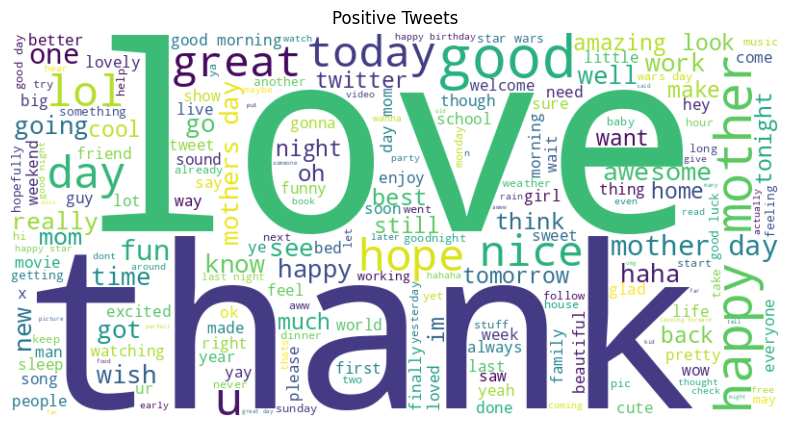

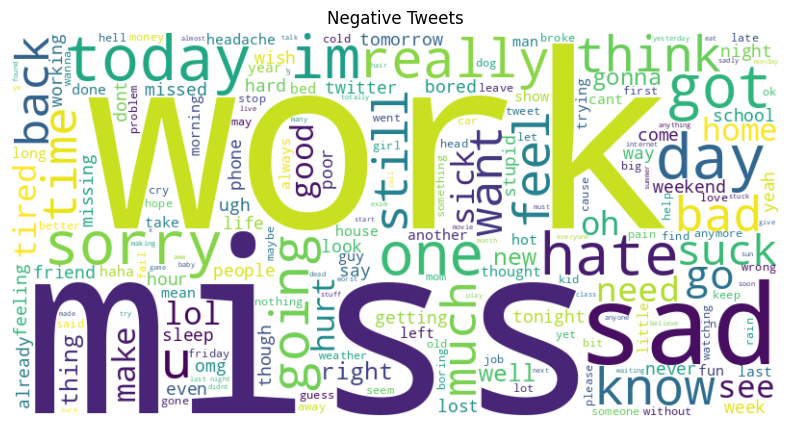

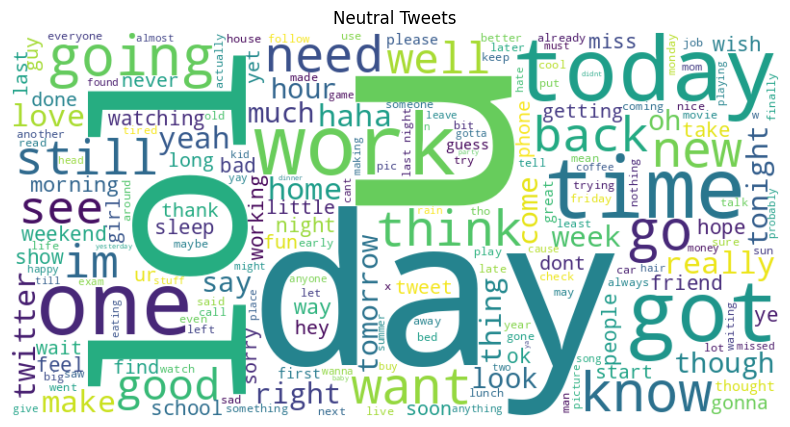

In [83]:
# prompt: create word cloud for posiitve_twt, negative and neutral /

from wordcloud import WordCloud

# Function to create and display a word cloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Create word clouds for each sentiment
create_wordcloud(positive_twt['processed_text'], 'Positive Tweets')
create_wordcloud(negative_twt['processed_text'], 'Negative Tweets')
create_wordcloud(neutral_twt['processed_text'], 'Neutral Tweets')

In [84]:
# convert sentiment to numeric
twt_df["sentiment"] = twt_df["sentiment"].map({"positive": 1, "negative": 0, "neutral": 1})


In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(twt_df, test_size = 0.2, stratify = twt_df["sentiment"], random_state = 123)
X_train, X_val = train_test_split(X_train, test_size = 0.1, stratify = X_train["sentiment"], random_state = 123)

X_train.shape, X_val.shape, X_test.shape

((19785, 4), (2199, 4), (5496, 4))

In [86]:
X_train["sentiment"].value_counts()

,count
sentiment,
1,14183
0,5602


In [87]:
X_val["sentiment"].value_counts()

,count
sentiment,
1,1576
0,623


In [88]:
X_test["sentiment"].value_counts()

,count
sentiment,
1,3940
0,1556


# Train and test data

In [89]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train["text"].values, X_train["sentiment"].values)).shuffle(1024).batch(batch_size = 128)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val["text"].values, X_val["sentiment"].values)).batch(batch_size = 128)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test["text"].values, X_test["sentiment"].values)).batch(batch_size = 128)

len(raw_train_ds), len(raw_val_ds), len(raw_test_ds)

(155, 18, 43)

# Vectorize text

In [90]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "count",
    ngrams = (1, 2)
)

In [91]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)

count_vectorizer.adapt(train_text)

In [92]:
def vectorize_text(text, label):
    # Shape () => (1, )
    text = tf.expand_dims(text, -1)

    return count_vectorizer(text), label

In [93]:
import sys
np.set_printoptions(threshold = sys.maxsize)

class_names = ["negative", "neutral", "positive"]
text_batch, label_batch = next(iter(raw_train_ds))
first_tweet, first_label = text_batch[0], label_batch[0]

print("Tweet: ", first_tweet)
print("Sentiment: ", class_names[first_label])
print("Vectorized review: ", vectorize_text(first_tweet, first_label))

Tweet:  tf.Tensor(b'Is dreading going to work  BUT....its friiiiiday!! whoop!!!', shape=(), dtype=string)
Sentiment:  neutral
Vectorized review:  (<tf.Tensor: shape=(1, 10000), dtype=int64, numpy=
array([[4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Apply Text Vectorization

In [94]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [95]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Define your DNN

In [96]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

# Model parameters

In [97]:
dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

input_shape = (None, 10000)

dnn_model.build(input_shape)

dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642,243 (2.45 MB)

 Trainable params: 642,243 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

# Train DNN Model

In [98]:
history = dnn_model.fit(
    train_ds,
    epochs = 10,
    validation_data = train_ds)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.6829 - loss: 0.9061 - val_accuracy: 0.7198 - val_loss: 0.6848
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7281 - loss: 0.6567 - val_accuracy: 0.7380 - val_loss: 0.5748
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7564 - loss: 0.5624 - val_accuracy: 0.7989 - val_loss: 0.4912
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8012 - loss: 0.4867 - val_accuracy: 0.8421 - val_loss: 0.4239
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8311 - loss: 0.4263 - val_accuracy: 0.8628 - val_loss: 0.3732
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8485 - loss: 0.3803 - val_accuracy: 0.8769 - val_loss: 0.3358
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8663 - loss: 0.3441 - val_accuracy: 0.8874 - val_loss: 0.3064
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8787 - loss: 0.3133 - val_accuracy:

In [99]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.8104 - loss: 0.4400
Loss:  0.4402919411659241
Accuracy:  0.8144105076789856


In [100]:
history_dict = history.history

history_dict

{'accuracy': [0.7076573371887207,
  0.7282789945602417,
  0.761384904384613,
  0.8044983744621277,
  0.8332069516181946,
  0.8525145053863525,
  0.8686378598213196,
  0.879605770111084,
  0.8886024951934814,
  0.896942138671875],
 'loss': [0.8199527263641357,
  0.6358212828636169,
  0.5471746921539307,
  0.4741860628128052,
  0.4173063039779663,
  0.3728453516960144,
  0.33922889828681946,
  0.3116450607776642,
  0.29184579849243164,
  0.27172112464904785],
 'val_accuracy': [0.7197877168655396,
  0.7380338907241821,
  0.7988880276679993,
  0.842102587223053,
  0.8627748489379883,
  0.8769269585609436,
  0.8873894214630127,
  0.8973970413208008,
  0.9049785137176514,
  0.9121556878089905],
 'val_loss': [0.6848119497299194,
  0.5747882723808289,
  0.49122199416160583,
  0.4239419102668762,
  0.3732398748397827,
  0.3358288109302521,
  0.3064388334751129,
  0.2829853296279907,
  0.2628574073314667,
  0.24582767486572266]}

# Training and Validation Loss Evaluation

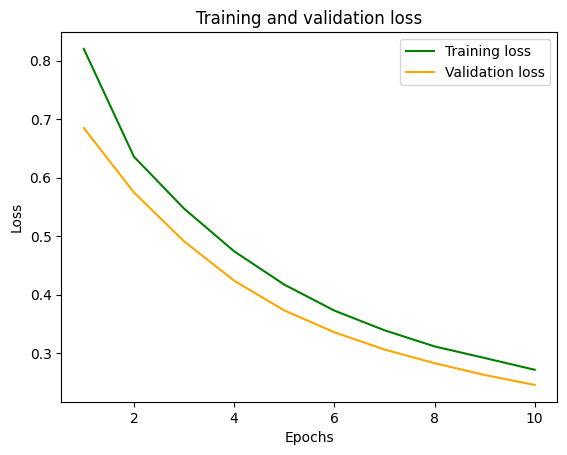

In [101]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Training and Validation Accuracy Evaluation

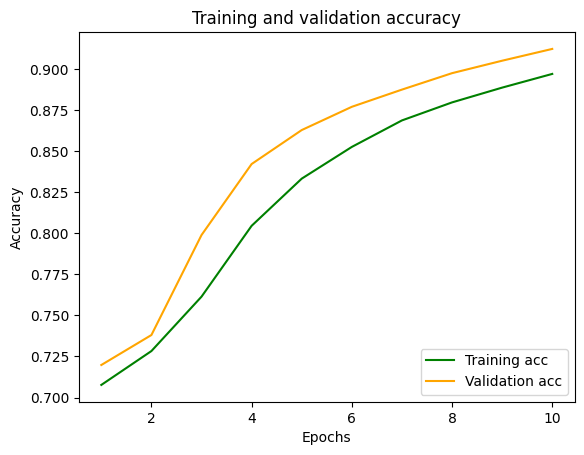

In [102]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [103]:
export_model = Sequential([
  count_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
results = export_model.evaluate(raw_test_ds)
# print(accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8104 - loss: 0.0000e+00


In [104]:
results

[0.0, 0.0, 0.8144105076789856, 0.8144105076789856]

In [105]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["text"].values)

y_pred = np.argmax(predictions , axis = 1)
y_test = X_test["sentiment"]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test, y_pred, average = None)
recall = recall_score(y_test, y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
              precision    recall  f1-score   support

           0       0.71      0.59      0.64      1556
           1       0.85      0.90      0.87      3940

    accuracy                           0.81      5496
   macro avg       0.78      0.75      0.76      5496
weighted avg       0.81      0.81      0.81      5496



#Train using tf-idf

In [106]:
vocab_size = 30

tfidf_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "tf-idf",
)

In [107]:
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

In [108]:
tfidf_vectorizer.adapt(text)

In [109]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 'is',
 'malcolm',
 'a',
 'well',
 'watching',
 'too',
 'teaching',
 'teacher',
 'quite',
 'painter',
 'loves',
 'in',
 'he',
 'footballer',
 'experienced',
 'decent',
 'dean',
 'cricket',
 'cooks',
 'chris',
 'an',
 'amazing',
 'also']

In [110]:
tfidf_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=float32, numpy=
array([[0.        , 0.6931472 , 1.6945957 , 0.        , 0.        ,
        1.0986123 , 0.        , 0.        , 0.        , 0.        ,
        1.0986123 , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.0986123 , 0.        ,
        0.        , 1.0986123 , 1.0986123 , 1.0986123 ],
       [0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.0986123 , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.6931472 , 0.84729785, 0.84729785, 0.        ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0

In [111]:
vocab_size = 10000

tfidf_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "tf-idf",
    ngrams = (1, 2)
)

tfidf_vectorizer.adapt(train_text)

In [112]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 'day',
 'good',
 'get',
 'like',
 'go',
 'today',
 'love',
 'work',
 'going',
 'got',
 'one',
 'happy',
 'lol',
 'u',
 'time',
 'back',
 'know',
 'really',
 'im',
 'see',
 'night',
 'home',
 'think',
 'want',
 'new',
 'still',
 'oh',
 'well',
 'thanks',
 'much',
 'great',
 'hope',
 'miss',
 'need',
 'haha',
 'last',
 'morning',
 'fun',
 'feel',
 'tomorrow',
 'twitter',
 'wish',
 'would',
 'bad',
 'sad',
 'tonight',
 'sorry',
 'right',
 'make',
 'week',
 'mother',
 'nice',
 'gonna',
 'though',
 'weekend',
 'way',
 'sleep',
 'better',
 'yeah',
 'could',
 'come',
 'people',
 'bed',
 'getting',
 'mother day',
 'next',
 'school',
 'awesome',
 'dont',
 'mothers',
 'watching',
 'wait',
 'days',
 'hate',
 'mom',
 'soon',
 'say',
 'best',
 'thing',
 'yes',
 'long',
 'hey',
 'never',
 'even',
 'working',
 'thank',
 'ok',
 'happy mother',
 'show',
 'done',
 'little',
 'take',
 'may',
 'look',
 'everyone',
 'mothers day',
 'guys',
 'cool',
 'cant',
 'feeling',
 'sick',
 'life',
 'first'

In [113]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return tfidf_vectorizer(text), label

In [114]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [115]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

# DNN Model

In [116]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

history = dnn_model.fit(
    train_ds,
    epochs = 40,
    validation_data = val_ds
)

Epoch 1/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 215ms/step - accuracy: 0.0783 - loss: 1.5945 - val_accuracy: 0.1610 - val_loss: 1.2387
Epoch 2/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3354 - loss: 1.1684 - val_accuracy: 0.6667 - val_loss: 0.9478
Epoch 3/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6324 - loss: 0.9234 - val_accuracy: 0.7103 - val_loss: 0.8124
Epoch 4/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7008 - loss: 0.8050 - val_accuracy: 0.7140 - val_loss: 0.7417
Epoch 5/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7139 - loss: 0.7432 - val_accuracy: 0.7185 - val_loss: 0.6975
Epoch 6/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7260 - loss: 0.6964 - val_accuracy: 0.7244 - val_loss: 0.6662
Epoch 7/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7330 - loss: 0.6668 - val_accuracy: 0.7276 - val_loss: 0.6421
Epoch 8/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7447 - loss: 0.6343 - val_accuracy:

In [117]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.8094 - loss: 0.4417
Loss:  0.44526606798171997
Accuracy:  0.8127729296684265


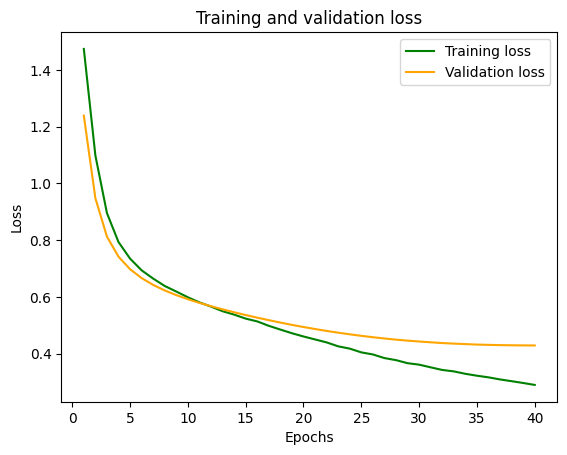

In [118]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

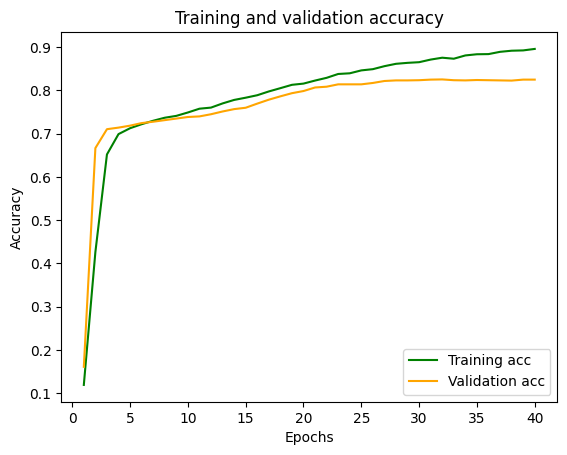

In [119]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [120]:
export_model = Sequential([
  tfidf_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
results = export_model.evaluate(raw_test_ds)
# print(accuracy)
results

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8094 - loss: 0.0000e+00


[0.0, 0.0, 0.8127729296684265, 0.8127729296684265]

# Represent text using integer seqeunces

In [132]:
vocab_size = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length
)

In [133]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [134]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [135]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [136]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Training ADNN using embeddings

In [137]:

callback_list = [
    keras.callbacks.EarlyStopping(
        patience = 3,
        monitor = "val_accuracy"
    ),

    keras.callbacks.ReduceLROnPlateau(
        patience = 1,
        factor = 0.1,
    )
]

In [138]:
embedding_dim = 64

model = Sequential([
  layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(64, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(32, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(3)]
)

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [139]:
model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = True),
               metrics = ["accuracy"])

history = model.fit(
    train_ds,
    epochs = 50,
    validation_data = val_ds,
    callbacks = callback_list
)

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7141 - loss: 0.6448 - val_accuracy: 0.7167 - val_loss: 0.5999 - learning_rate: 0.0010
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7204 - loss: 0.6037 - val_accuracy: 0.7167 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7215 - loss: 0.5951 - val_accuracy: 0.7167 - val_loss: 0.5956 - learning_rate: 0.0010
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7216 - loss: 0.5949 - val_accuracy: 0.7167 - val_loss: 0.5936 - learning_rate: 0.0010


In [140]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7149 - loss: 0.5958
Loss:  0.5937093496322632
Accuracy:  0.7168850302696228


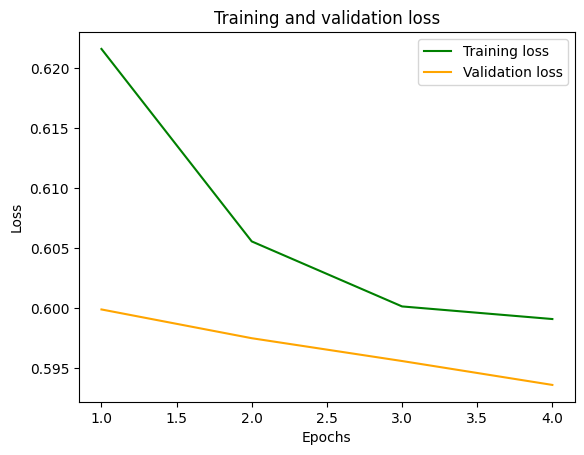

In [141]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


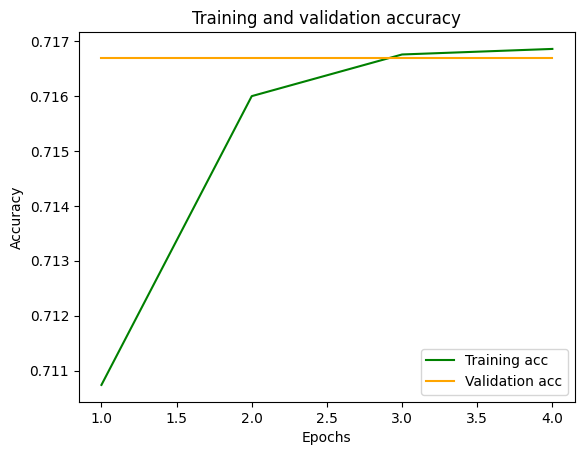

In [142]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

# Using RNN

In [152]:
embedding_dim = 128

rnn_model = Sequential()

rnn_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

rnn_model.add(layers.SimpleRNN(128, return_sequences = True))

rnn_model.add(layers.GlobalMaxPool1D())

rnn_model.add(layers.Dense(3, activation = "softmax"))

rnn_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = rnn_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.7039 - loss: 0.6326 - val_accuracy: 0.8213 - val_loss: 0.4137 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8492 - loss: 0.3595 - val_accuracy: 0.8327 - val_loss: 0.3999 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9027 - loss: 0.2544 - val_accuracy: 0.8254 - val_loss: 0.4224 - learning_rate: 0.0010


In [153]:
loss, accuracy = rnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7968 - loss: 0.4677
Loss:  0.4611929655075073
Accuracy:  0.801128089427948


# Simple LSTM model

In [154]:
embedding_dim = 128

lstm_model = Sequential()

lstm_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

lstm_model.add(layers.SpatialDropout1D(0.25))

lstm_model.add(layers.LSTM(128, dropout = 0.6, return_sequences = True))

lstm_model.add(layers.GlobalMaxPooling1D())

lstm_model.add(layers.Dense(32, activation = "tanh"))
lstm_model.add(layers.Dense(3, activation = "softmax"))

lstm_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = lstm_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7075 - loss: 0.6480 - val_accuracy: 0.8108 - val_loss: 0.4244 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8253 - loss: 0.4049 - val_accuracy: 0.8354 - val_loss: 0.3951 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8580 - loss: 0.3398 - val_accuracy: 0.8377 - val_loss: 0.3903 - learning_rate: 0.0010


In [155]:
loss, accuracy = lstm_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8227 - loss: 0.4299
Loss:  0.42800313234329224
Accuracy:  0.8229621648788452


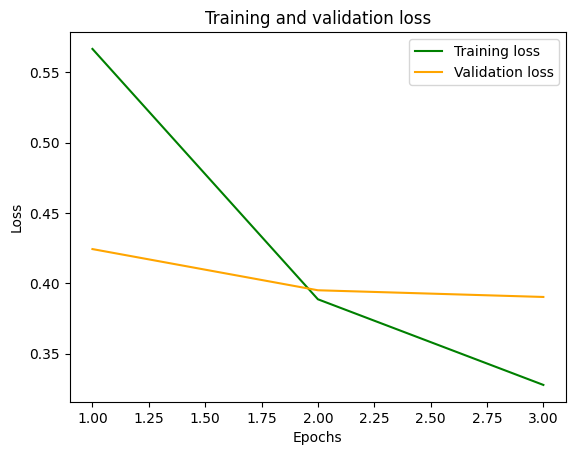

In [156]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

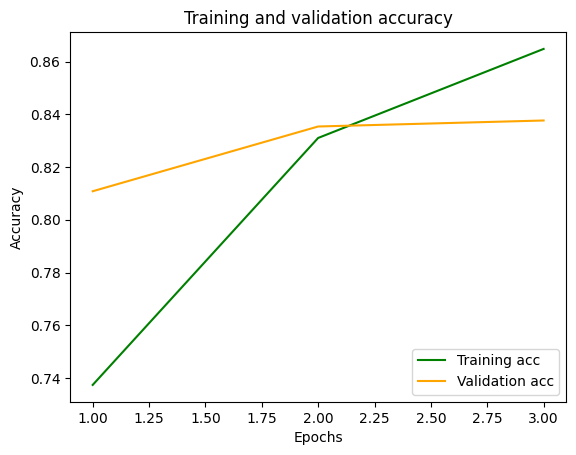

In [157]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [164]:
export_model = Sequential([
  vectorize_layer,
  lstm_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    optimizer = optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
results = export_model.evaluate(raw_test_ds)
print(results)

examples = [
  "this experience has been the worst, want my money back",
  "this AI related article is very good",
  "The movie was average" ]


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8208 - loss: 0.0000e+00
[0.0, 0.0, 0.8213245868682861, 0.8213245868682861]


ValueError: Unrecognized data type: x=['this experience has been the worst, want my money back', 'this AI related article is very good', 'The movie was average'] (of type <class 'list'>)

In [165]:

export_model.predict(examples)

ValueError: Unrecognized data type: x=['this experience has been the worst, want my money back', 'this AI related article is very good', 'The movie was average'] (of type <class 'list'>)

In [166]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["text"].values)
y_pred = np.argmax(predictions , axis = 1)

y_test = X_test["sentiment"]
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test,y_pred, average = None)
recall = recall_score(y_test,y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
              precision    recall  f1-score   support

           0       0.74      0.57      0.65      1556
           1       0.84      0.92      0.88      3940

    accuracy                           0.82      5496
   macro avg       0.79      0.75      0.76      5496
weighted avg       0.82      0.82      0.81      5496



In [167]:
lstm_model.save("sentiment_predictor.keras")